0.4644082332761578
N_Bins: 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      2498
       Relay       0.46      1.00      0.63      2166

    accuracy                           0.46      4664
   macro avg       0.23      0.50      0.32      4664
weighted avg       0.22      0.46      0.29      4664



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

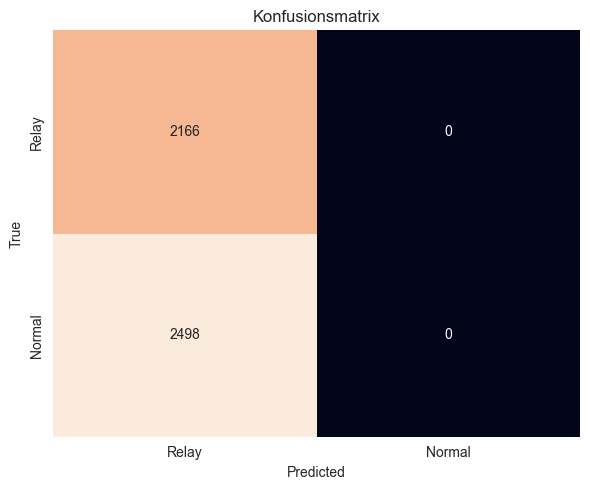

N_Bins: 20

Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      2498
       Relay       0.46      1.00      0.63      2166

    accuracy                           0.46      4664
   macro avg       0.23      0.50      0.32      4664
weighted avg       0.22      0.46      0.29      4664



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

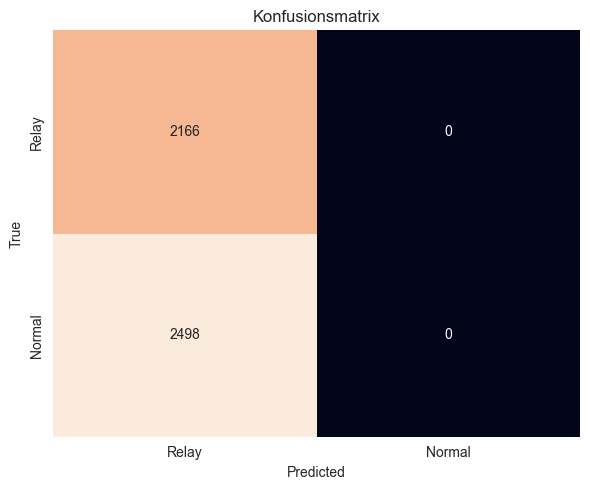

N_Bins: 30

Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      2498
       Relay       0.46      1.00      0.63      2166

    accuracy                           0.46      4664
   macro avg       0.23      0.50      0.32      4664
weighted avg       0.22      0.46      0.29      4664



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

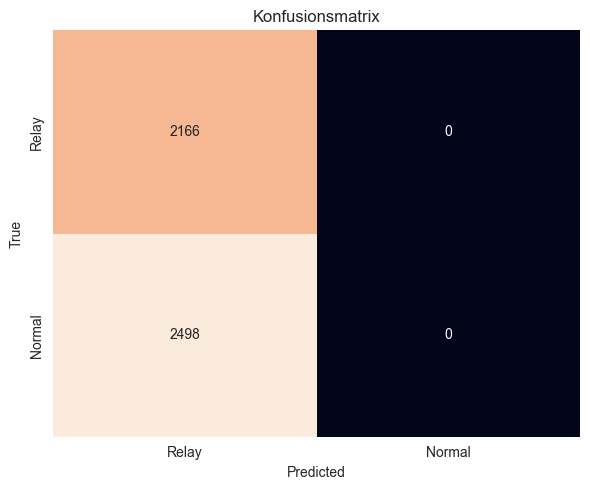

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from pyod.models.kde import KDE

# daten laden
normal_path = "transients/S01/1/Normal/q_data"
relay_path  = "transients/S01/1/Relay/q_data"

with h5py.File('datasets/transients_cleaned_padded.h5', 'r') as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49998, n_norm))
    dataset_relay  = np.zeros((49666, n_relay))

    for i in range(49998):
        dataset_normal[i] = normal_group[str(i)][:]
    for i in range(49666):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

# daten definieren und skalieren
scaler = MinMaxScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]      # 4998 Normal
X_test_relay          = dataset_relay[47500:]        # 4998 Relay

scaler.fit(X_train)
X_train_scaled        = scaler.transform(X_train)
X_test_norm_scaled    = scaler.transform(X_test_normal)
X_test_relay_scaled   = scaler.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled = np.vstack((X_test_norm_scaled, X_test_relay_scaled))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

print(len(X_test_relay)/len(X_test_combined))
# modell trainieren, contamination gibt an, wie viele outlier man im trainigsdatensatz hat
# contamination kann man bei reiner novelty detection zb auf 0.01 oder 0.05 setzen
for n in {20,30,50}:
    clf = KDE(contamination=0.01, leaf_size=n)
    clf.fit(X_train)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"N_Bins: {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()

0.4644082332761578
N_Bins: 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      2498
       Relay       0.46      1.00      0.63      2166

    accuracy                           0.46      4664
   macro avg       0.23      0.50      0.32      4664
weighted avg       0.22      0.46      0.29      4664



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

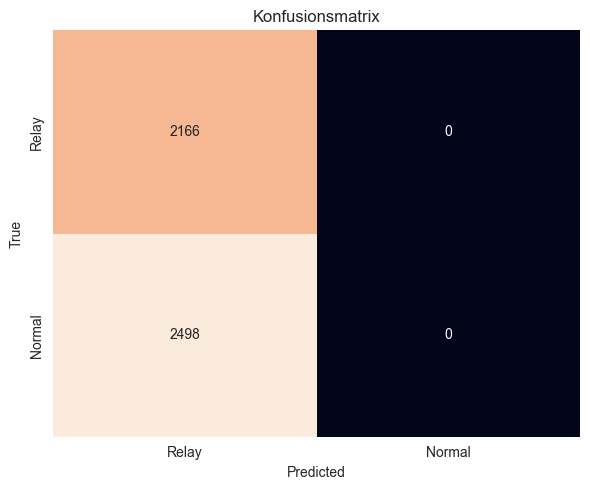

N_Bins: 20

Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      2498
       Relay       0.46      1.00      0.63      2166

    accuracy                           0.46      4664
   macro avg       0.23      0.50      0.32      4664
weighted avg       0.22      0.46      0.29      4664



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

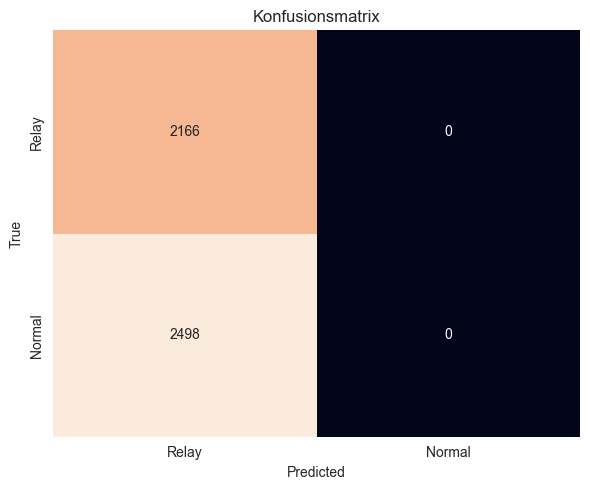

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from pyod.models.kde import KDE

# daten laden
normal_path = "transients/S01/1/Normal/q_data"
relay_path  = "transients/S01/1/Relay/q_data"

with h5py.File('datasets/transients_cleaned_padded.h5', 'r') as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49998, n_norm))
    dataset_relay  = np.zeros((49666, n_relay))

    for i in range(49998):
        dataset_normal[i] = normal_group[str(i)][:]
    for i in range(49666):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

# daten definieren und skalieren
scaler = MinMaxScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]      # 4998 Normal
X_test_relay          = dataset_relay[47500:]        # 4998 Relay

scaler.fit(X_train)
X_train_scaled        = scaler.transform(X_train)
X_test_norm_scaled    = scaler.transform(X_test_normal)
X_test_relay_scaled   = scaler.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled = np.vstack((X_test_norm_scaled, X_test_relay_scaled))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

print(len(X_test_relay)/len(X_test_combined))
# modell trainieren, contamination gibt an, wie viele outlier man im trainigsdatensatz hat
# contamination kann man bei reiner novelty detection zb auf 0.01 oder 0.05 setzen
for n in {20,30,50}:
    clf = KDE(contamination=0.01, leaf_size=n, metric="manhattan")
    clf.fit(X_train)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"N_Bins: {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()